In [1]:
import pandas as pd
import numpy as np
import os
import math

In [2]:
df = pd.read_csv('final_csvs/all_risk_df_ordered_no_log.csv', index_col=0)

In [3]:
df = df.fillna(0)

In [4]:
df = df.rename({'ranking_y':'ranking'}, axis=1)

In [5]:
df.head()

,matchId,teamId,distance1_2_x,distance1_3_x,distance1_4_x,distance2_3_x,distance2_4_x,distance3_4_x,distance_centroid1_x,distance_centroid2_x,...,landing_risk3,landing_risk4,risk1,risk2,risk3,risk4,risk_std1,risk_std2,risk_std3,risk_std4
0,000fe633-8af8-4037-b318-a1ca39ded6df,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,2.121320
1,000fe633-8af8-4037-b318-a1ca39ded6df,2,0.000000,0.000000,0.000000,418.390210,414.514679,30.646491,0.000000,276.378251,...,49.0,0.0,4.100000,8.076923,2.650000,0.000000,6.463664,11.732511,2.661124,0.000000
2,000fe633-8af8-4037-b318-a1ca39ded6df,3,866.615796,858.782483,840.942177,258.785781,223.967544,47.645528,638.547728,254.697789,...,1.0,0.0,0.731707,1.694301,0.450777,0.201258,1.830544,4.923881,0.934808,0.582225
3,000fe633-8af8-4037-b318-a1ca39ded6df,4,425.944425,417.198576,321.380618,321.229675,154.322329,30.468740,241.120643,187.078206,...,0.0,0.0,0.553191,0.322581,0.414894,0.232558,1.528349,0.768416,0.781638,0.546097
4,000fe633-8af8-4037-b318-a1ca39ded6df,5,186.757953,188.940699,184.901774,36.051585,28.180701,17.629798,137.930967,50.013119,...,0.0,0.0,0.630058,0.444444,0.568047,0.408602,1.843158,0.871572,1.252301,0.875221


First, we look at how many teams have null values in the distance columns, meaning that the teams are of less than 4 people. We look for 99s because we previously made all the distance nans to have value 99. 

In [6]:
for c in df.columns:
    if ('distance' in c) and ('y' in c):
        nns = len([i for i in df[c] if i == 99])
        total = len(df[c])
        print(f'{c} has {(nns/total)*100}% null values')

distance1_2_y has 29.446577849904703% null values
distance1_3_y has 29.378172588832484% null values
distance1_4_y has 29.377464948200704% null values
distance2_3_y has 10.598097861981772% null values
distance2_4_y has 10.541014851018058% null values
distance3_4_y has 6.586247240201535% null values
distance_centroid1_y has 29.587398335629235% null values
distance_centroid2_y has 11.227190383635573% null values
distance_centroid3_y has 7.206612194063366% null values
distance_centroid4_y has 0.0% null values


Then, we drop them. We decide to focus only on 4-player teams.

In [7]:
df = df.replace(99, np.nan)
df = df.dropna()
df = df.drop('n_players_y', axis=1)

For the risk variable, we derive a new interaction variable. This is risk * risk_std since we saw that they were highly correlated, so we try to capture the effect of the variance in risk with another variable.

In [8]:
df['risk_int1'] = df['risk1'] * df['risk_std1']
df['risk_int2'] = df['risk2'] * df['risk_std2']
df['risk_int3'] = df['risk3'] * df['risk_std3']
df['risk_int4'] = df['risk4'] * df['risk_std4']
df = df.drop(['risk_std1','risk_std2','risk_std3','risk_std4'], axis=1)

Now, we order risk variables from highest to lowest, so that the new variables represent from the riskiest player to the least risky player.

In [9]:
risk = df.loc[:, 'risk1':'risk4']
risk = np.sort(risk.values, axis=1)[:,::-1]
df.loc[:, 'risk1':'risk4'] = risk
risk_std = df.loc[:, 'risk_int1':'risk_int4']
risk_std = np.sort(risk_std.values, axis=1)[:,::-1]
df.loc[:, 'risk_int1':'risk_int4'] = risk_std
lrisk = df.loc[:, 'landing_risk1':'landing_risk4']
lrisk = np.sort(lrisk.values, axis=1)[:,::-1]
df.loc[:, 'landing_risk1':'landing_risk4'] = lrisk

Since the sum of the Cluster columns is always 1, we have a very high correlation. For that reason, we drop one of them. In this case, we drop Cluster A because we see that it is the one with the highest correlation with the others.

In [10]:
df.loc[:,'cluster_A_x':'cluster_D_x'].corr()

,cluster_A_x,cluster_B_x,cluster_C_x,cluster_D_x
cluster_A_x,1.000000,0.752828,0.826139,0.680459
cluster_B_x,0.752828,1.000000,0.440376,0.219371
cluster_C_x,0.826139,0.440376,1.000000,0.690342
cluster_D_x,0.680459,0.219371,0.690342,1.000000


In [11]:
df.loc[:,'cluster_A_y':'cluster_D_y'].corr()

,cluster_A_y,cluster_B_y,cluster_C_y,cluster_D_y
cluster_A_y,1.000000,-0.924651,-0.896358,-0.724987
cluster_B_y,-0.924651,1.000000,0.683865,0.473274
cluster_C_y,-0.896358,0.683865,1.000000,0.743550
cluster_D_y,-0.724987,0.473274,0.743550,1.000000


In [12]:
df = df.drop(['cluster_A_x','cluster_A_y'], axis=1)

Now, we merge rankpoints

In [13]:
rkpts = pd.read_csv('experience_data/rankpoints_csv.csv', index_col=0)
df = pd.merge(df, rkpts, how='left', on=['matchId', 'teamId'])

Next, we create the control variables for all the groups of variable.
We will use as control the mean of each group for the match. E.g. for pair distances, we will control for the mean pair player distance of the match.

In [14]:
group = df.groupby(['matchId']).mean().reset_index()
mean_distance = pd.concat([group.matchId, group[['distance1_2_y', 'distance1_3_y', 'distance1_4_y', 'distance2_3_y', 'distance2_4_y', 'distance3_4_y']].apply(np.mean, axis=1)], axis=1)
mean_distance.columns = ['matchId','distance_ctrl']
mean_centroid = pd.concat([group.matchId, group[['distance_centroid1_y', 'distance_centroid2_y', 'distance_centroid3_y', 'distance_centroid4_y']].apply(np.mean, axis=1)], axis=1)
mean_centroid.columns = ['matchId','centroid_ctrl']
mean_cluster = pd.concat([group.matchId, group[['cluster_B_y', 'cluster_C_y','cluster_D_y']].apply(np.mean, axis=1)], axis=1)
mean_cluster.columns = ['matchId','cluster_ctrl']
mean_exp = pd.concat([group.matchId, group[['exp1', 'exp2', 'exp3', 'exp4']].apply(np.mean, axis=1)], axis=1)
mean_exp.columns = ['matchId','exp_ctrl']
mean_risk = pd.concat([group.matchId, group[['risk1', 'risk2', 'risk3', 'risk4']].apply(np.mean, axis=1)], axis=1)
mean_risk.columns = ['matchId','risk_ctrl']
# mean_lrisk = pd.concat([group.matchId, group[['landing_risk1', 'landing_risk2', 'landing_risk3', 'landing_risk4']].apply(np.mean, axis=1)], axis=1)
# mean_lrisk.columns = ['matchId','landing_risk_ctrl']
mean_agi = group[['matchId', 'agility_y']]
mean_agi.columns = ['matchId','agi_ctrl']
df = pd.merge(df, mean_distance, how = 'left', on="matchId")
df = pd.merge(df, mean_centroid, how = 'left', on="matchId")
df = pd.merge(df, mean_cluster, how = 'left', on="matchId")
df = pd.merge(df, mean_exp, how = 'left', on="matchId")
df = pd.merge(df, mean_risk, how = 'left', on="matchId")
# df = pd.merge(df, mean_lrisk, how = 'left', on="matchId")
df = pd.merge(df, mean_agi, how = 'left', on="matchId")

Now, since experience was already a control variable, we are going to engineer the variable. For that, we are going to normalize the experiences of the palyers by the mean experience of the match, and then we are going to get the aggregate experience for the team. We sum 1 to the denominator in case there is some mean exp that is equal to 0.

In [15]:
df['exp1'] = df['exp1'] / (df['exp_ctrl'] + 1)
df['exp2'] = df['exp2'] / (df['exp_ctrl'] + 1)
df['exp3'] = df['exp3'] / (df['exp_ctrl'] + 1)
df['exp4'] = df['exp4'] / (df['exp_ctrl'] + 1)
df['exp'] = df['exp1'] + df['exp2'] + df['exp3'] + df['exp4']
df = df.drop(['exp1','exp2','exp3','exp4', 'exp_ctrl'], axis=1)

Since we have many players for whom we don't know the experience, we are going to drop them.<br><BR>
(NOT SURE ABOUT THIS, I THINK IT MAKES THE MODEL WORSE SO I COMMENTED IT) Then, we are going to recalculate the rankings for our regression tasks. The goal is to show the ranking in the match of the teams that we have information about. E.g. if for a match we only have 4 teams left, ranks 1,5,9,11, the new ranks will be 1,2,3,4 respectively.

In [16]:
df = df.dropna()
# for match in df.matchId.unique():
#     df.loc[df.matchId == match,'new_ranking'] = df.loc[df.matchId == match,'ranking'].rank()

To make things easiear, we make sure that ranking is the last column.

In [17]:
ranking = df.pop('ranking')
df.insert(df.shape[1], 'ranking', ranking)

Since we have many variables ordered, we drop the middle variables to stay only with max and min variables (they don't add much to the model).

In [18]:
df = df.drop(['distance1_3_x', 'distance1_4_x', 'distance2_3_x', 'distance2_4_x',
              'distance1_3_y', 'distance1_4_y', 'distance2_3_y', 'distance2_4_y', 
              'distance_centroid2_x', 'distance_centroid3_x', 'distance_centroid2_y', 'distance_centroid3_y',
              'risk2', 'risk3', 'risk_int2', 'risk_int3', 'landing_risk2','landing_risk3'], axis=1)

Now, let's remove the outliers. For that, we use the Z-score, and we will remove all rows with z-score bigger than 3 (3 standard deviations away from the mean)

In [26]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df.iloc[:,1:]))
print(z)

[[0.1799266  0.55332913 0.3962748  ... 0.57538345 0.74629194 1.14389719]
 [1.22431012 0.66914013 0.37480063 ... 0.57538345 0.74629194 1.21979657]
 [1.38664867 1.09392372 1.37261448 ... 0.79668337 0.74629194 0.82584761]
 ...
 [1.22431012 0.07275725 0.11394716 ... 0.74111496 0.74629194 1.14389719]
 [1.35485806 0.44855327 0.29275763 ... 0.74111496 0.74629194 0.09336663]
 [1.87704981 0.36119159 0.38189299 ... 0.74111496 0.74629194 1.53784615]]


In [27]:
df = df[(z < 3).all(axis=1)]

In [29]:
df.shape

(114940, 30)

Then, we separate the two df that we are going to study

In [30]:
pd.set_option('display.max_columns', 48)
pd.DataFrame(df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,matchId,teamId,distance1_2_x,distance3_4_x,distance_centroid1_x,distance_centroid4_x,cluster_B_x,cluster_C_x,cluster_D_x,distance1_2_y,distance3_4_y,distance_centroid1_y,distance_centroid4_y,cluster_B_y,cluster_C_y,cluster_D_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_int1,risk_int4,distance_ctrl,centroid_ctrl,cluster_ctrl,risk_ctrl,agi_ctrl,exp,ranking


In [32]:
# distances and centroids
df1 = pd.concat([df.iloc[:,0:6], df.iloc[:,9:13], df.iloc[:,16:25], df.iloc[:,26:]], axis=1)

# distances and clusters
df2 = pd.concat([df.iloc[:,0:4], df.iloc[:,6:11], df.iloc[:,13:24], df.iloc[:,25:]], axis=1)


Here, I just check the correlations. There is probably something that we can do about high correlations, though.

In [33]:
df2.iloc[:,2:].corr().style.apply(lambda x: ["background: red" if abs(v) > 0.75 else "" for v in x], axis = 1)

,distance1_2_x,distance3_4_x,cluster_B_x,cluster_C_x,cluster_D_x,distance1_2_y,distance3_4_y,cluster_B_y,cluster_C_y,cluster_D_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_int1,risk_int4,distance_ctrl,cluster_ctrl,risk_ctrl,agi_ctrl,exp,ranking
distance1_2_x,1,0.414817,0.236468,0.415656,0.36185,0.759874,0.15439,0.347467,0.375799,0.302084,-0.121588,-0.173454,-0.23653,-0.150584,-0.286486,-0.10558,-0.208863,0.41961,0.381677,-0.324497,-0.104551,-0.0897837,0.0916788
distance3_4_x,0.414817,1,0.238348,0.595959,0.811978,0.484154,0.679887,0.41519,0.626462,0.800824,0.036444,-0.247628,-0.255173,-0.241907,-0.30662,-0.172822,-0.232421,0.331822,0.343753,-0.279895,-0.0263965,-0.0644315,0.00708147
cluster_B_x,0.236468,0.238348,1,0.435173,0.219175,0.261618,0.116764,0.681127,0.275687,0.152003,0.0777444,-0.198956,-0.279179,-0.230232,-0.353458,-0.166509,-0.280966,0.216853,0.290799,-0.210424,-0.0454265,-0.065534,-0.104686
cluster_C_x,0.415656,0.595959,0.435173,1,0.652275,0.529731,0.473086,0.667792,0.882083,0.557412,0.0569772,-0.314775,-0.360228,-0.328578,-0.433845,-0.24052,-0.331826,0.348778,0.427455,-0.336066,-0.0714645,-0.0858028,-0.0213415
cluster_D_x,0.36185,0.811978,0.219175,0.652275,1,0.443678,0.628172,0.429233,0.697334,0.922221,-0.0141817,-0.269572,-0.269581,-0.272618,-0.327825,-0.195223,-0.241948,0.320427,0.367372,-0.30247,-0.0762635,-0.0622566,-0.0316122
distance1_2_y,0.759874,0.484154,0.261618,0.529731,0.443678,1,0.327116,0.607781,0.569336,0.408853,-0.0765011,-0.17314,-0.241717,-0.150829,-0.297125,-0.103853,-0.224151,0.344565,0.334236,-0.222776,-0.0998646,-0.076022,0.0542857
distance3_4_y,0.15439,0.679887,0.116764,0.473086,0.628172,0.327116,1,0.373405,0.571373,0.667721,0.442877,-0.208553,-0.152318,-0.272911,-0.207148,-0.196224,-0.166416,0.1698,0.176359,-0.187244,0.166485,-0.033826,0.0492621
cluster_B_y,0.347467,0.41519,0.681127,0.667792,0.429233,0.607781,0.373405,1,0.639744,0.376995,0.104115,-0.228196,-0.308498,-0.227311,-0.374532,-0.163699,-0.297376,0.25738,0.349577,-0.208199,-0.0671918,-0.0572977,0.028957
cluster_C_y,0.375799,0.626462,0.275687,0.882083,0.697334,0.569336,0.571373,0.639744,1,0.668891,0.042148,-0.272477,-0.290095,-0.270378,-0.354506,-0.197127,-0.269063,0.284024,0.360024,-0.255134,-0.0674363,-0.0485885,0.0223094
cluster_D_y,0.302084,0.800824,0.152003,0.557412,0.922221,0.408853,0.667721,0.376995,0.668891,1,-0.00838098,-0.225049,-0.21407,-0.222485,-0.263002,-0.159061,-0.192889,0.24459,0.291881,-0.228476,-0.0573846,-0.0351114,-0.00814767


# EDA

In [34]:
pd.set_option('display.max_columns', 45)

In [35]:
df.columns

Index(['matchId', 'teamId', 'distance1_2_x', 'distance3_4_x',
       'distance_centroid1_x', 'distance_centroid4_x', 'cluster_B_x',
       'cluster_C_x', 'cluster_D_x', 'distance1_2_y', 'distance3_4_y',
       'distance_centroid1_y', 'distance_centroid4_y', 'cluster_B_y',
       'cluster_C_y', 'cluster_D_y', 'agility_y', 'landing_risk1',
       'landing_risk4', 'risk1', 'risk4', 'risk_int1', 'risk_int4',
       'distance_ctrl', 'centroid_ctrl', 'cluster_ctrl', 'risk_ctrl',
       'agi_ctrl', 'exp', 'ranking'],
      dtype='object')

The _x_ variables represent standard deviations, while the _y_ variables represent means

In [36]:
df.nunique(axis=0)
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,teamId,distance1_2_x,distance3_4_x,distance_centroid1_x,distance_centroid4_x,cluster_B_x,cluster_C_x,cluster_D_x,distance1_2_y,distance3_4_y,distance_centroid1_y,distance_centroid4_y,cluster_B_y,cluster_C_y,cluster_D_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_int1,risk_int4,distance_ctrl,centroid_ctrl,cluster_ctrl,risk_ctrl,agi_ctrl,exp,ranking
count,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000,114940.000000
mean,12.632156,276.835428,26.081491,182.902804,66.400699,0.133287,0.065075,0.022676,219.668535,11.739200,141.125369,33.004392,0.111718,0.031764,0.006323,0.235841,28.132212,3.116709,10.380347,3.484958,271.404874,40.420265,135.782720,100.073469,0.052338,7.677194,0.230696,1.545283,11.951244
std,7.650503,261.940847,17.817458,179.745997,66.778765,0.045193,0.043898,0.030192,212.971038,13.535791,142.576943,41.664850,0.072181,0.034797,0.011568,0.111202,29.261688,5.403291,11.299985,4.234180,507.246989,82.731115,75.600353,57.581284,0.017268,5.000453,0.043905,2.053146,7.548345
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.990000,-9.990000,0.000000,-9.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.711253,17.894473,0.005455,0.000000,0.086309,0.000000,1.000000
25%,6.000000,90.663995,14.730439,56.939605,21.022654,0.111803,0.030888,0.000000,91.716285,1.366865,56.836017,8.151482,0.052632,0.003788,0.000000,0.152542,6.000000,0.000000,1.975207,0.563953,7.045294,0.664467,76.629146,54.543314,0.038918,3.636356,0.201929,0.000000,5.000000
50%,12.000000,179.528005,21.200776,115.412006,40.279900,0.136578,0.067937,0.000000,149.566447,10.471444,93.334347,21.019587,0.105372,0.019170,0.000000,0.225000,19.000000,1.000000,6.115385,1.615385,55.664606,4.675466,115.574519,84.468859,0.052218,6.410416,0.232375,0.000000,11.000000
75%,18.000000,376.235666,31.954520,246.952041,87.326392,0.160985,0.102763,0.043073,261.380136,19.285435,165.371723,41.920667,0.161458,0.050000,0.007576,0.304878,40.000000,3.125000,15.232558,4.990898,291.635788,38.917160,179.284729,132.782489,0.065330,11.318209,0.260538,3.644614,18.000000
max,35.000000,1520.404224,130.824519,1022.569499,399.497493,0.255377,0.170437,0.113067,1575.496200,83.974246,1047.002988,305.063169,0.352151,0.163194,0.062500,0.590909,150.000000,30.000000,60.676471,22.368421,3697.413697,734.343312,397.222493,301.199904,0.103504,23.386239,0.367601,7.720557,33.000000


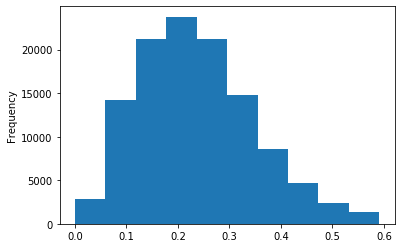

In [37]:
df['agility_y'].plot.hist()

# Models

In [38]:
import numpy as np
import pandas as pd
import os
import math
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDClassifier
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier, XGBRegressor

## All variables

From now on, I use the df with distances and cluster, not centroids

In [55]:
X = df2.iloc[:,2:-1]
y = df2.iloc[:,[-1]]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=6, shuffle=True)

In [54]:
# Scale between 0 and 1
scaler= StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [68]:
X_train=pd.DataFrame(X_train, columns=X.columns)
X_test=pd.DataFrame(X_test, columns=X.columns)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Regression

In [66]:
# Linear Regression
X_t=sm.add_constant(X_train)
model = sm.OLS(y_train,X_t.astype(float)).fit()

model.summary()

C:\Users\admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     2297.
Date:                Sat, 27 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:14:40   Log-Likelihood:            -2.9631e+05
No. Observations:               91952   AIC:                         5.927e+05
Df Residuals:                   91929   BIC:                         5.929e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.2389      0.202     65.599      0.000      12.843      13.634
distance1_2_x     0.0037      0.000     27.416      0.000       0.003       0.004
distance3_4_x     0.0510      0.002     22.512      0.000       0.047       0.055
cluster_B_x     -46.1261      0.715    -64.551      0.000     -47.527     -44.726
cluster_C_x     -41.0215      1.186    -34.592      0.000     -43.346     -38.697
cluster_D_x     -53.5097      1.992    -26.864      0.000     -57.414     -49.606
distance1_2_y    -0.0023      0.000    -11.938      0.000      -0.003      -0.002
distance3_4_y    -0.1927      0.003    -66.161      0.000      -0.198      -0.187
cluster_B_y      24.5867      0.592     41.542      0.000      23.427      25.747
cluster_C_y      44.2754      1.567     28.248      0.000      41.203      47.347
cluster_D_y     152.0003      5.174     29.376      0.000     141.859     162.142
agility_y        38.7646      0.241    160.859      0.000      38.292      39.237
landing_risk1    -0.0183      0.001    -19.124      0.000      -0.020      -0.016
landing_risk4    -0.0481      0.005    -10.450      0.000      -0.057      -0.039
risk1             0.3811      0.006     61.848      0.000       0.369       0.393
risk4             0.1757      0.016     11.280      0.000       0.145       0.206
risk_int1        -0.0048      0.000    -42.308      0.000      -0.005      -0.005
risk_int4        -0.0094      0.001    -14.499      0.000      -0.011      -0.008
distance_ctrl     0.0025      0.000      5.165      0.000       0.002       0.003
cluster_ctrl     -1.1503      2.333     -0.493      0.622      -5.723       3.422
risk_ctrl        -0.5339      0.006    -83.884      0.000      -0.546      -0.521
agi_ctrl        -14.3768      0.518    -27.732      0.000     -15.393     -13.361
exp              -0.1256      0.010    -12.652      0.000      -0.145      -0.106
==============================================================================
Omnibus:                     1125.647   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              957.265
Skew:                           0.190   Prob(JB):                    1.36e-208
Kurtosis:                       2.675   Cond. No.                     1.69e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
y_pred = model.predict(X_t)

In [68]:
metrics.r2_score(y_train, y_pred)

0.3546977543605283

In [69]:
mean_squared_error(y_train, y_pred)

36.85257681431997

In [70]:
X_ts = sm.add_constant(X_test)
y_pred = model.predict(X_ts)

C:\Users\admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [71]:
metrics.r2_score(y_test, y_pred)

0.3452298564021141

In [72]:
mean_squared_error(y_test, y_pred)

36.96112401319832

In [49]:
# Linear regression (scikit learn)
kfold=KFold(n_splits=10, random_state=7)

model=LinearRegression()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print(f'Linear Regression - MSE {results.mean():.3f} std {results.std():.3f}')

# Create the DataFrames for plotting
resall=pd.DataFrame()
res_w1=pd.DataFrame()

res_w1["Res"]=results
res_w1["Type"]="Lin"

resall=pd.concat([resall,res_w1], ignore_index=True)

# Now lets use it in the same way than the statsmodel

model_x=LinearRegression()
model_x.fit(X_train,y_train)
print(f'Intercept {model_x.intercept_}')
print("Coefficients ",model_x.coef_)

y_pred_x=model_x.predict(X_train)

print(f'MAE - Mean Absolute Error {mean_absolute_error(y_train, y_pred_x):.3f}')
print(f'MSE - Mean Square Error  {mean_squared_error(y_train, y_pred_x):.3f}')
print(f'R2    {metrics.r2_score(y_train, y_pred_x):.3f}')

Linear Regression - MSE -36.837 std 0.426
Intercept [13.19931627]
Coefficients  [[ 3.74522076e-03  5.23488240e-02 -4.61221959e+01 -4.12204998e+01
  -5.27908328e+01 -2.33134603e-03 -1.93569436e-01  2.43481651e+01
   4.49949005e+01  1.48812119e+02  3.86995860e+01 -1.84051686e-02
  -4.64996887e-02  3.81413377e-01  1.79547393e-01 -4.77291989e-03
  -9.84865639e-03  2.57353341e-03 -1.96696794e+00 -5.33308866e-01
  -1.40413867e+01 -1.24841807e-01]]
MAE - Mean Absolute Error 4.952
MSE - Mean Square Error  36.819
R2    0.354


In [50]:
y_pred = model_x.predict(X_test)

In [201]:
# Ridge Regression
kfold=KFold(n_splits=10, random_state=7)

model=Ridge()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

print(f'Ridge Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="Ridge"

resall=pd.concat([resall,res_w1], ignore_index=True)

Ridge Regression - MSE -40.297 std 0.578


In [202]:
model=Ridge()
model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [203]:
y_pred = model.predict(X_train)

In [204]:
metrics.r2_score(y_train, y_pred)

0.30242606619619694

In [205]:
mean_squared_error(y_train, y_pred)

40.274078246631724

In [206]:
y_pred = model.predict(X_test)

In [207]:
metrics.r2_score(y_test, y_pred)

0.3073767795872324

In [208]:
mean_squared_error(y_test, y_pred)

39.60672799782415

In [ ]:
# KNN Regression
kfold=KFold(n_splits=10, random_state=7)

model=KNeighborsRegressor()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

print(f'KNN Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="KNN"

resall=pd.concat([resall,res_w1], ignore_index=True)

In [209]:
model=KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
y_pred = model.predict(X_train)

In [ ]:
metrics.r2_score(y_train, y_pred)

In [ ]:
mean_squared_error(y_train, y_pred)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
metrics.r2_score(y_test, y_pred)

In [ ]:
mean_squared_error(y_test, y_pred)

### Classification

In [241]:
dfc = df2.copy()
dfc['ranking'] = dfc['ranking'].apply(lambda x: 1 if x <=5 else 0)

In [242]:
X = dfc.iloc[:,2:-1]
y = dfc.iloc[:,-1]

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=6, shuffle = True)

In [198]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LOGISTIC REGRESSION

In [303]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [304]:
y_pred = model.predict(X_train)
print('TRAIN METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_train, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_train, y_pred)}')
metrics.confusion_matrix(y_train,y_pred)

TRAIN METRICS
Accuracy: 0.6638753309726608
F1 Score: 0.5086160662236212


array([[61430, 33953],
       [ 8193, 21812]], dtype=int64)

In [305]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.64      0.74     95383
           1       0.39      0.73      0.51     30005

    accuracy                           0.66    125388
   macro avg       0.64      0.69      0.63    125388
weighted avg       0.76      0.66      0.69    125388



In [306]:
y_pred = model.predict(X_test)
print('TEST METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test,y_pred)

TEST METRICS
Accuracy: 0.6641785688652838
F1 Score: 0.5061741424802111


array([[6856, 3781],
       [ 898, 2398]], dtype=int64)

In [307]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.64      0.75     10637
           1       0.39      0.73      0.51      3296

    accuracy                           0.66     13933
   macro avg       0.64      0.69      0.63     13933
weighted avg       0.77      0.66      0.69     13933



STOCHASTIC GRADIENT DESCENT

In [204]:
model = SGDClassifier(class_weight='balanced')
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [205]:
y_pred = model.predict(X_train)
print('TRAIN METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_train, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_train, y_pred)}')
metrics.confusion_matrix(y_train,y_pred)

TRAIN METRICS
Accuracy: 0.6949389096245254
F1 Score: 0.7061209751150516


array([[41183, 26900],
       [11351, 45954]], dtype=int64)

In [206]:
y_pred = model.predict(X_test)
print('TEST METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test,y_pred)

TEST METRICS
Accuracy: 0.6887963826885811
F1 Score: 0.7003041194359968


array([[4531, 3067],
       [1269, 5066]], dtype=int64)

XGBCLASSIFIER

In [150]:
len([i for i in y_train if i == 0]) / len([i for i in y_train if i == 1])

3.128414478139815

In [294]:
model = XGBClassifier(scale_pos_weight=2.5, booster='gbtree', gamma=65, min_child_weight=50)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [295]:
y_pred = model.predict(X_train)
print('TRAIN METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_train, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_train, y_pred)}')
metrics.confusion_matrix(y_train,y_pred)

TRAIN METRICS
Accuracy: 0.763932752735509
F1 Score: 0.6022681465158153


array([[73377, 22006],
       [ 7594, 22411]], dtype=int64)

In [296]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83     95383
           1       0.50      0.75      0.60     30005

    accuracy                           0.76    125388
   macro avg       0.71      0.76      0.72    125388
weighted avg       0.81      0.76      0.78    125388



In [297]:
metrics.average_precision_score(y_train,y_pred)

0.43742363973360326

In [298]:
metrics.roc_auc_score(y_pred,y_train)

0.7053862004307303

In [299]:
y_pred = model.predict(X_test)
print('TEST METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test,y_pred)

TEST METRICS
Accuracy: 0.7561185674298428
F1 Score: 0.5835784313725491


array([[8154, 2483],
       [ 915, 2381]], dtype=int64)

In [300]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83     10637
           1       0.49      0.72      0.58      3296

    accuracy                           0.76     13933
   macro avg       0.69      0.74      0.71     13933
weighted avg       0.80      0.76      0.77     13933



In [301]:
metrics.average_precision_score(y_test,y_pred)

0.4192924060248118

In [302]:
metrics.roc_auc_score(y_pred,y_test)

0.6943108250670299

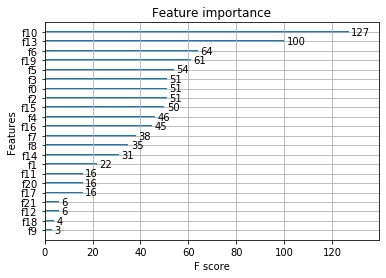

In [239]:
from xgboost import plot_importance
plot_importance(model.get_booster())

In [240]:
pd.DataFrame(X.columns)

,0
0,distance1_2_x
1,distance3_4_x
2,cluster_B_x
3,cluster_C_x
4,cluster_D_x
5,distance1_2_y
6,distance3_4_y
7,cluster_B_y
8,cluster_C_y
9,cluster_D_y
